In [1]:
from eda import get_objectives, get_constraints, non_dominated_sort, non_dominated, assign_crowding_distance, binary_tournament_selection, sample_population, cleanupsamples, generate_example_data, organize_results

In [2]:
from numpy import random
import numpy as np
from scipy.stats import gamma, norm
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal as mvn
from scipy.spatial.distance import jensenshannon
from numba import jit
import math
from hdf5storage import loadmat, savemat
import pickle

In [3]:
def transform_items_to_z(items):
    alpha = np.empty(items.shape[1])
    beta = np.empty(items.shape[1])
    items_z = np.empty(items.shape)
    items_r = items + 1
    for i in range(items_r.shape[1]):
        a, loc, scale = gamma.fit(items_r[:, i], floc=0.0)
        alpha[i] = a
        beta[i] = scale
        u = gamma.cdf(items_r[:,i], a = a, scale = scale)
        u = np.clip(u, 1e-12, 1-1e-12)
        items_z[:,i] = norm.ppf(u) 
    return alpha, beta, items_z

In [4]:
# def convert_to_long(YY, n_selected, n_obj, n_con):
#     rows = []
#     for j in range(n_selected):
#         for k in range(n_obj+n_con):
#             if k < n_obj:
#                 rows.append(pd.DataFrame({
#                     'cumulative': YY[:,j, k],
#                     'step': f'Step {j}',
#                     'objective': f'Obj {k}'
#                 }))
#             else:
#                 rows.append(pd.DataFrame({
#                     'cumulative': YY[:,j, k],
#                     'step': f'Step {j}',
#                     'objective': f'Con {k-n_obj}',
#                 }))
#     df_Y = pd.concat(rows, ignore_index=True)
#     return df_Y

# def ecdf(df_table,n_selected,n_obj,n_con):
#     nk = len(df_table)/(n_selected*(n_obj+n_con))
#     ecdf_table = np.zeros((n_selected,(n_obj+n_con),int(nk)))
#     for t in range(1,n_selected):
#         for i in range(n_obj+n_con):
#             if i < n_obj:
#                 ecdf_table[t,i,:] = np.sort(df_table['cumulative'][(df_table['objective'] == f'Obj {i}')&(df_table['step'] == f'Step {t}')].values)
#             else:
#                 ecdf_table[t,i,:] = np.sort(df_table['cumulative'][(df_table['objective'] == f'Con {i - n_obj}')&(df_table['step'] == f'Step {t}')].values)
#     return ecdf_table

# def z_transform_from_ecdf(Y, ecdf_table):
#     N, d = Y.shape  
#     Y_z = np.empty_like(Y)
#     for t in range(1,N):
#         for i in range(d):
#             ranks = np.searchsorted(ecdf_table[t,i,:], Y[t, i], side='right')
#             u = ranks / len(ecdf_table[t,i,:])
#             u = np.clip(u, 1e-12, 1 - 1e-12)
#             Y_z[t, i] = norm.ppf(u) 
#     return Y_z

def fit_gamma_y_to_z(YY, XX_z):
    N, T, d = YY.shape
    YY_z = np.empty((N, T, d), dtype=float)
    YY_z[:, 0, :] = XX_z[:, 0, :] 
    shape = np.full((T-1, d), np.nan)
    location = np.full((T-1, d), np.nan)
    scale = np.full((T-1, d), np.nan)
    for t in range(1, T):
        for i in range(d):
            y = YY[:, t, i]
            y_r = y + 1
            
            # check
            # if not np.all(np.isfinite(y_r)):
            #     raise ValueError("y_r has non-finite values")
            # if np.any(y_r <= 0):
            #     raise ValueError(f"y_r has non-positive values, min={y_r.min()}")
            # if np.var(y_r) == 0:
            #     raise ValueError("y_r is constant; gamma MLE is ill-posed")
            if np.ptp(y_r) < 1e-12:
                raise RuntimeError(
                    f"Gamma degenerate at t={t}, i={i}\n"
                    f"unique(y_r)={np.unique(y_r)}\n"
                    f"min={y_r.min()}, max={y_r.max()}\n"
                    f"population size={YY.shape[0]}"
                    f"XX_z= {XX_z[:,t,i]}"
                )

            a, loc, b = gamma.fit(y_r, floc=0.0)
            u = gamma.cdf(y_r, a=a, loc=loc, scale=b)
            u = np.clip(u, 1e-12, 1 - 1e-12)
            YY_z[:, t, i] = norm.ppf(u)
            shape[t-1, i] = a
            location[t-1, i] = loc
            scale[t-1, i] = b
    return YY_z, shape, location, scale

In [5]:
def get_norm_cumu_objectives(items, items_z, population, n_selected, n_obj, n_con, rng, if_initial):  # can modify to use objectives instead of population
    XX = np.empty((population.shape[0], n_selected, n_obj+n_con))
    XX_z = np.empty((population.shape[0], n_selected, n_obj+n_con))
    for k in range(population.shape[0]):
        if if_initial:
            qx = rng.permutation(population[k, :]) # permutation only for initial population
        else:
            qx = population[k, :]
        XX[k,:,:] = items[qx,:]
        XX_z[k,:,:] = items_z[qx,:]
    YY = np.cumsum(XX, axis = 1)
    YY_z, shape, location, scale = fit_gamma_y_to_z(YY, XX_z)
    return XX, XX_z, YY, YY_z, shape, location, scale

In [6]:
def fit_markov_in_y_by_t(X, Y):
    K, N, d = X.shape
    A_list = np.zeros((N-1, d, d))
    b_list = np.zeros((N-1, d))
    Q_list = np.zeros((N-1, d, d))
    R2_list = np.zeros(N-1)
    reg_list = []

    for t in range(1, N):  
        S_t = Y[:, t-1, :]  
        Z_t = X[:, t,   :] 
        reg_t = LinearRegression(fit_intercept=True)
        reg_t.fit(S_t, Z_t)
        A_t = reg_t.coef_      # (d, d)
        b_t = reg_t.intercept_ # (d,)
        Z_hat_t = reg_t.predict(S_t)
        R_t = Z_t - Z_hat_t
        Q_t = np.cov(R_t, rowvar=False, bias=False)
        r2 = reg_t.score(S_t, Z_t)

        A_list[t-1, :, :] = A_t
        b_list[t-1, :] = b_t
        Q_list[t-1, :, :] = Q_t
        R2_list[t-1] = r2
        reg_list.append(reg_t)
    params = {"A": A_list,"b": b_list,"Q": Q_list,"regs": reg_list,"R2": R2_list}
    return params

In [7]:
def fit_conditional(items, items_z, population, n_selected, n_obj, n_con, rng, if_initial):
    objectives, objectives_z, cumu_objectives, cumu_objectives_z, shape, location, scale = get_norm_cumu_objectives(items, items_z, population, 
                                                                                                                        n_selected, n_obj, n_con, 
                                                                                                                        rng, if_initial)
    dist_params = fit_markov_in_y_by_t(objectives_z, cumu_objectives_z)
    return objectives_z, dist_params, shape, location, scale

In [8]:
def conditional_density_given_Y_and_t(X_candidates, y_normal, params_time, t):
    A_all = params_time["A"]  
    b_all = params_time["b"]  
    Q_all = params_time["Q"]  

    A_t = A_all[t-1]
    b_t = b_all[t-1]
    Q_t = Q_all[t-1]
    X_candidates = np.asarray(X_candidates)
    y_normal = np.asarray(y_normal).reshape(-1)
    mean_t = A_t @ y_normal + b_t
    Q_t = Q_t + 1e-3 * np.eye(Q_t.shape[0])

    densities = mvn.pdf(X_candidates, mean=mean_t, cov=Q_t)
    return densities

# def get_conditional_params(dist_params):
#     A_all = dist_params["A"]
#     b_all = dist_params["b"]
#     Q_all = dist_params["Q"]
    
#     conditional_models = []
#     for t in range(len(Q_all)):
#         Q_t = Q_all[t] + 1e-3 * np.eye(Q_all[t].shape[0])
#         mvn_cond = mvn(mean=np.zeros(Q_t.shape[0]), cov=Q_t)
#         conditional_models.append({
#             "A": A_all[t],
#             "b": b_all[t],
#             "mvn_cond": mvn_cond
#         })
#     return conditional_models

# def calculate_probs_conditional(model, x_candidates, y_normal):
    # A_t = model["A"]
    # b_t = model["b"]
    # mvn_cond = model["mvn_cond"]
    
    # mean_t = A_t @ y_normal + b_t
    # centered_candidates = x_candidates - mean_t  # center x candidates to 0
    
    # densities = mvn_cond.pdf(centered_candidates)
    # probabilities = densities / np.sum(densities)
    # return probabilities

In [9]:
def base_rate_model(items_z, XX_0):
    mean0 = np.mean(XX_0, axis = 0)
    Sigma0 = np.cov(XX_0.T) 
    # add regularization to diagonal for singularity
    Sigma0 = Sigma0 + 1e-3 * np.eye(Sigma0.shape[0])
    mvn0 = mvn(mean=mean0, cov=Sigma0)
    x_candidates = items_z
    probabilities = mvn0.pdf(x_candidates)
    probabilities = (probabilities+1e-12)/sum(probabilities+1e-12)
    return probabilities

# def get_base_model_params(items_z, XX_0):
#     mean0 = np.mean(XX_0, axis=0)
#     Sigma0 = np.cov(XX_0.T)
#     # may add regularization here
#     mvn0 = mvn(mean=mean0, cov=Sigma0)
#     return mvn0

# def calculate_probs_base(model, x_candidates):
#     probabilities = model.pdf(x_candidates)
#     probabilities = (probabilities + 1e-12) / np.sum(probabilities + 1e-12)
#     return probabilities

In [ ]:
# def sample_population_conditional(
#     samples, samples_z, objectives_z, dist_params,
#     pop_size, n_selected, capacity, rng): # no use of rng

#     pop_count = 0
#     population = np.zeros((pop_size, n_selected), dtype=np.int32)
#     n_items = samples.shape[0]

#     while pop_count < pop_size:
#         # select sequentially
#         knapsack = np.zeros(n_selected, dtype=int) # here knapsack is knapsack indices
#         for n in range(n_selected):
#             if n == 0: # select first item
#                 probabilities = base_rate_model(samples_z, objectives_z[:, 0, :])
#                 first_choice = rng.choice(n_items, p=probabilities)
#                 first_item = samples_z[first_choice,:]
#                 x_indices = np.setdiff1d(np.arange(n_items), knapsack)
#                 y_prev = first_item 
#                 knapsack[0] = first_choice
#             else:
#                 x_indices = np.setdiff1d(np.arange(n_items), knapsack[:n])
#                 x_candidates = samples_z[x_indices, :]
#                 densities = conditional_density_given_Y_and_t(
#                     x_candidates, y_prev, dist_params, n
#                 )
#                 probabilities = densities/sum(densities)
#                 next_choice = rng.choice(len(probabilities), p=probabilities)
#                 next_index = x_indices[next_choice]
#                 next_item = samples_z[next_index,:]
#                 knapsack[n] = next_index
#                 y_prev = y_prev + next_item
        
#         constraint = np.sum(samples[knapsack, -1])
#         if constraint <= capacity:
#             population[pop_count, :] = knapsack
#             pop_count += 1
    
#     return population

In [10]:
def sample_population_conditional_initial(
    samples, samples_z, objectives_z, dist_params,
    shape, location, scale, if_converged, XX_z_all,
    pop_size, n_selected, n_obj, n_con, capacity, rng):

    pop_count = 0
    population = np.zeros((pop_size, n_selected), dtype=np.int32)
    n_items = samples.shape[0]

    while pop_count < pop_size:
        knapsack_indices = np.zeros(n_selected, dtype=int)    
        knapsack = np.zeros((n_selected,(n_obj+n_con)))

        probabilities = base_rate_model(samples_z, XX_z_all[:,0,:])
        first_choice = rng.choice(n_items, p=probabilities)
        knapsack_indices[0] = first_choice
        knapsack[0, :] = samples[first_choice, :]
        y_prev_z = samples_z[first_choice, :] 
        y_cum = knapsack[0, :].copy()

        for n in range(1, n_selected):
            x_indices = np.setdiff1d(np.arange(n_items), knapsack_indices[:n])   
            x_candidates = samples_z[x_indices, :] 
            densities = conditional_density_given_Y_and_t(x_candidates, y_prev_z, dist_params, n)
            probabilities = densities/sum(densities)

            next_choice = rng.choice(len(probabilities), p=probabilities)
            next_index = x_indices[next_choice]
            knapsack_indices[n] = next_index
            knapsack[n, :] = samples[next_index, :]
            
            # normalize y
            y_cum += knapsack[n, :]
            u = gamma.cdf(y_cum, a=shape[n-1, :], loc=location[n-1, :], scale=scale[n-1, :])
            u = np.clip(u, 1e-12, 1-1e-12)
            y_prev_z = norm.ppf(u)
        
        constraint = np.sum(samples[knapsack_indices, -1])
        if constraint <= capacity:
            population[pop_count, :] = knapsack_indices
            pop_count += 1

    return population

In [11]:
def sample_population_conditional(
    samples, samples_z, objectives_z, dist_params,
    shape, location, scale, if_converged,
    pop_size, n_selected, n_obj, n_con, capacity, rng):

    pop_count = 0
    population = np.zeros((pop_size, n_selected), dtype=np.int32)
    n_items = samples.shape[0]

    while pop_count < pop_size:
        knapsack_indices = np.zeros(n_selected, dtype=int)    
        knapsack = np.zeros((n_selected,(n_obj+n_con)))

        probabilities = base_rate_model(samples_z, objectives_z[:, 0, :]) # sample first item from base rate model
        first_choice = rng.choice(n_items, p=probabilities)
        knapsack_indices[0] = first_choice
        knapsack[0, :] = samples[first_choice, :]
        y_prev_z = samples_z[first_choice, :] 
        y_cum = knapsack[0, :].copy()

        for n in range(1, n_selected):
            x_indices = np.setdiff1d(np.arange(n_items), knapsack_indices[:n])   
            x_candidates = samples_z[x_indices, :] 
            densities = conditional_density_given_Y_and_t(x_candidates, y_prev_z, dist_params, n)
            probabilities = densities/sum(densities)
            next_choice = rng.choice(len(probabilities), p=probabilities)
            next_index = x_indices[next_choice]
            knapsack_indices[n] = next_index
            knapsack[n, :] = samples[next_index, :]
            
            # normalize y
            y_cum += knapsack[n, :]
            u = gamma.cdf(y_cum, a=shape[n-1, :], loc=location[n-1, :], scale=scale[n-1, :])
            u = np.clip(u, 1e-12, 1-1e-12)
            y_prev_z = norm.ppf(u)
        
        constraint = np.sum(samples[knapsack_indices, -1])
        if constraint <= capacity:
            population[pop_count, :] = knapsack_indices
            pop_count += 1
    
    return population

In [ ]:
## parallel processing sampling function
# import multiprocessing
# from functools import partial
# from scipy.special import gammainc, ndtri

# def _sample_chunk(seed, chunk_size, samples, samples_z, base_model_params, cond_models, 
#                   shape, location, scale,
#                   n_selected, n_obj, n_con, capacity):
#     rng = np.random.default_rng(seed)
#     n_items = samples.shape[0]
#     population_chunk = np.zeros((chunk_size, n_selected), dtype=np.int32)
#     pop_count = 0
#     total_attempts = 0
    
#     while pop_count < chunk_size:
#         total_attempts += 1
        
#         knapsack_indices = np.zeros(n_selected, dtype=int)    
#         knapsack = np.zeros((n_selected, (n_obj + n_con)))
        
#         probabilities = calculate_probs_base(base_model_params, samples_z)
#         first_choice = rng.choice(n_items, p=probabilities)
#         knapsack_indices[0] = first_choice
#         knapsack[0, :] = samples[first_choice, :]
#         y_prev_z = samples_z[first_choice, :]     
#         for n in range(1, n_selected):
#             x_indices = np.setdiff1d(np.arange(n_items), knapsack_indices[:n])   
#             x_candidates = samples_z[x_indices, :] 
#             # step n (1 to N-1) corresponds to cond_models n-1
#             probs = calculate_probs_conditional(cond_models[n-1], x_candidates, y_prev_z)
#             next_choice_idx = rng.choice(len(probs), p=probs)
#             next_index = x_indices[next_choice_idx]
#             knapsack_indices[n] = next_index
#             knapsack[n, :] = samples[next_index, :]
            
#             # normalize y
#             u = gamma.cdf(knapsack[n, :], a=shape[n, :], loc=location[n, :], scale=scale[n, :])
#             # u = gammainc(shape[n, :], knapsack[n, :] / scale[n, :])
#             u = np.clip(u, 1e-12, 1-1e-12)
#             y_prev_z = norm.ppf(u)
     
#         constraint = np.sum(samples[knapsack_indices, -1])
#         if constraint <= capacity:
#             population_chunk[pop_count, :] = knapsack_indices
#             pop_count += 1
        
#         if total_attempts % 5000 == 0:
#             print(f"  Worker pid={multiprocessing.current_process().pid}: "
#                   f"Sampled {pop_count}/{chunk_size} (Attempts: {total_attempts})", flush=True)

                
#     return population_chunk

# def sample_population_conditional(
#     samples, samples_z, objectives_z, dist_params, 
#     shape, location, scale,
#     pop_size, n_selected, n_obj, n_con, capacity, rng):

#     base_model = get_base_model_params(samples_z, objectives_z[:, 0, :])
#     cond_models = get_conditional_params(dist_params)
    
#     n_jobs = multiprocessing.cpu_count()
#     chunk_size = pop_size // n_jobs
#     remainder = pop_size % n_jobs
#     chunks = [chunk_size] * n_jobs
#     if remainder > 0:
#         chunks[-1] += remainder
        
#     seeds = rng.integers(0, 1e9, size=n_jobs)
#     with multiprocessing.Pool(processes=n_jobs) as pool:
#         func = partial(_sample_chunk, 
#                        samples=samples, 
#                        samples_z=samples_z, 
#                        base_model_params=base_model,
#                        cond_models=cond_models,
#                        shape=shape,
#                        location=location,
#                        scale=scale,
#                        n_selected=n_selected,
#                        n_obj=n_obj,
#                        n_con=n_con, 
#                        capacity=capacity)
        
#         results = pool.starmap(func, zip(seeds, chunks))
        
#     population = np.vstack(results)
#     return population

In [12]:
class KnapsackEDACond:
    def __init__(self, items, capacity, n_selected, n_obj, n_con,
                 shape, location, scale, distribution_params, XX_z_all,
                 pop_size=1000, generations=10, max_no_improve_gen=10, max_iters=100, seed=1123):
        self.items = items
        self.capacity = capacity
        self.n_selected = n_selected
        self.n_obj = n_obj
        self.n_con = n_con
        self.pop_size = pop_size
        self.generations = generations
        self.max_no_improve_gen = max_no_improve_gen
        self.max_iters = max_iters
        self.rng = random.default_rng(seed=seed)

        self.items_z = None
        # self.ecdf_table = None
        self.shape = shape
        self.location = location
        self.scale = scale
        self.XX_z_all = XX_z_all
        self.if_inital = True
        self.if_converged = False
        self.if_initial_gen = True

        self.first_item_dist = None
        self.distribution_params = distribution_params
        self.selected_population = None  # (pop_size, n_selected)
        self.selected_objectives = None  # (pop_size, n_obj) objective values are summed over solutions
        self.objectives_z = None  # (pop_size, n_selected, n_obj)

        self.distribution_params_table = []
        self.pareto_indices_table = []
        self.pareto_front_table = []
        self.js_div_list = []
        self.converged_pf_table = []

    # def _generate_initial_population(self):
        # n_items = self.items.shape[0]
        # distribution = np.ones(n_items) / n_items
        # population = sample_population(
        #     self.items, distribution, self.pop_size, self.n_selected, 
        #     self.capacity, self.rng
        # )
        # objectives = get_objectives(self.items, population, self.n_obj)
        
        # ranks, fronts = non_dominated_sort(objectives)
        # distances_all_solutions = np.zeros(population.shape[0], dtype=float)
        # for f in fronts:
        #     distances = assign_crowding_distance(objectives[f, :])
        #     distances_all_solutions[f] = distances

        # select_indices = np.array([], dtype=int)
        # while len(select_indices) < self.pop_size:
        #     indice = binary_tournament_selection(
        #         population, ranks, distances_all_solutions, self.rng
        #     )
        #     select_indices = np.concatenate([select_indices, np.array([indice])])
        
        # selected_population = population[select_indices]
        # selected_objectives = objectives[select_indices]

        # _, _, self.items_z = transform_items_to_z(self.items)
        # self.objectives_z, self.distribution_params, self.shape, self.location, self.scale = fit_conditional(self.items, self.items_z, selected_population, 
        #                                                                                                         self.n_selected, self.n_obj, self.n_con,
        #                                                                                                         self.rng, self.if_inital) # may need a different rng
        # self.first_item_dist = base_rate_model(self.items_z, self.objectives_z[:, 0, :])
        # self.selected_population = selected_population
        # self.selected_objectives = selected_objectives
    
    def _generate_initial_population(self):
        population = sample_population_conditional_initial(
                self.items, self.items_z, self.objectives_z, self.distribution_params,
                self.shape, self.location, self.scale, self.if_converged, self.XX_z_all,
                self.pop_size, self.n_selected, self.n_obj, self.n_con, self.capacity, self.rng
            )
        objectives = get_objectives(self.items, population, self.n_obj)
        
        ranks, fronts = non_dominated_sort(objectives)
        distances_all_solutions = np.zeros(population.shape[0], dtype=float)
        for f in fronts:
            distances = assign_crowding_distance(objectives[f, :])
            distances_all_solutions[f] = distances

        select_indices = np.array([], dtype=int)
        while len(select_indices) < self.pop_size:
            indice = binary_tournament_selection(
                population, ranks, distances_all_solutions, self.rng
            )
            select_indices = np.concatenate([select_indices, np.array([indice])])
        
        selected_population = population[select_indices]
        selected_objectives = objectives[select_indices]

        self.objectives_z, self.distribution_params, self.shape, self.location, self.scale = fit_conditional(self.items, self.items_z, selected_population, 
                                                                                                                self.n_selected, self.n_obj, self.n_con,
                                                                                                                self.rng, self.if_inital) # may need a different rng
        self.first_item_dist = base_rate_model(self.items_z, self.objectives_z[:, 0, :])
        self.selected_population = selected_population
        self.selected_objectives = selected_objectives

    
    def _update_distribution(self):
        # sampling
        population = sample_population_conditional(
            self.items, self.items_z, self.objectives_z, self.distribution_params,
            self.shape, self.location, self.scale, self.if_converged,
            self.pop_size, self.n_selected, self.n_obj, self.n_con, self.capacity, self.rng
        )
        objectives = get_objectives(self.items, population, self.n_obj)
        
        # find current pareto front
        _, fronts_current = non_dominated_sort(objectives)
        pareto_indices = population[fronts_current[0]]
        
        # stack populations
        objectives = np.vstack((self.selected_objectives, objectives))
        population = np.vstack((self.selected_population, population))
        
        # select through non-dominated sorting
        ranks, fronts = non_dominated_sort(objectives)
        select_indices = np.array([], dtype=np.int32)
        for f in fronts:
            if len(select_indices) + len(f) <= self.pop_size:
                select_indices = np.concatenate([select_indices, f])
            else:
                remaining_size = self.pop_size - len(select_indices)
                f_distance = assign_crowding_distance(objectives[f, :])
                sort_indices = np.argsort(f_distance)[::-1]
                remaining = f[sort_indices[:remaining_size]]
                select_indices = np.concatenate([select_indices, remaining])
                break
        selected_population = population[select_indices]
        selected_objectives = objectives[select_indices]
        
        # determine training population
        # if self.if_converged:
        #     training_population = population[fronts[0]]
        # else:
        n_training = int(self.pop_size*0.15)
        training_population = selected_population[:n_training]
        
        # update distribution
        self.objectives_z, self.distribution_params, self.shape, self.location, self.scale= fit_conditional(self.items, self.items_z, training_population, 
                                                                                                                self.n_selected, self.n_obj, self.n_con,
                                                                                                                self.rng, self.if_inital)
        
        self.selected_population = selected_population
        self.selected_objectives = selected_objectives

        # compute js divergence
        updated_first_item_dist = base_rate_model(self.items_z, self.objectives_z[:, 0, :])
        self.first_item_dist[self.first_item_dist < 1E-08] = 1E-08
        updated_first_item_dist[updated_first_item_dist < 1E-08] = 1E-08
        js_div = jensenshannon(self.first_item_dist, updated_first_item_dist)**2
        self.first_item_dist = updated_first_item_dist
        
        return pareto_indices, js_div

    def _converged_pf(self):
        # sampling
        population = sample_population_conditional(
            self.items, self.items_z, self.objectives_z, self.distribution_params,
            self.shape, self.location, self.scale, self.if_converged,
            self.pop_size, self.n_selected, self.n_obj, self.n_con, self.capacity, self.rng)
        objectives = get_objectives(self.items, population, self.n_obj)

        # find current pareto front
        pareto_indices = population[non_dominated(objectives).astype(bool)]
        
        # stack populations
        population = np.unique(np.sort(np.vstack((self.selected_population, population)), axis=1), axis=0)
        objectives = get_objectives(self.items, population, self.n_obj)

        # select through non-dominated
        nd_idx = non_dominated(objectives).astype(bool)
        selected_population = population[nd_idx]
        selected_objectives = objectives[nd_idx]

        # update distribution
        self.objectives_z, self.distribution_params, self.shape, self.location, self.scale = fit_conditional(self.items, self.items_z, selected_population, 
                                                                                                                self.n_selected, self.n_obj, self.n_con,
                                                                                                                self.rng, self.if_inital)
        self.selected_population = selected_population
        self.selected_objectives = selected_objectives                                                                             
        
        return pareto_indices

    def run(self):
        _, _, self.items_z = transform_items_to_z(self.items)
        self._generate_initial_population()
        self.if_inital = False
        
        # Run generations (fixed number of generations)
        # for g in range(self.generations):
        #     print(f"Generation {g+1}/{self.generations}")
        #     pareto_indices, js_div = self._update_distribution()
        #     print(f"number of front 0: {pareto_indices.shape[0]}")
            
        #     pareto_front = np.zeros((pareto_indices.shape[0], self.items.shape[1]))
        #     for k in range(pareto_indices.shape[0]):
        #         pareto_front[k, :] = np.sum(self.items[pareto_indices[k, :], :], axis=0)
                
        #     self.distribution_params_table.append(self.distribution_params.copy())
        #     self.pareto_indices_table.append(pareto_indices.copy())
        #     self.pareto_front_table.append(pareto_front.copy())
        #     self.js_div_list.append(js_div)

        # return {
        #     'distribution_params_table': self.distribution_params_table,
        #     'pareto_indices_table': self.pareto_indices_table,
        #     'pareto_front_table': self.pareto_front_table,
        #     'js_div_list': self.js_div_list,
        #     'objectives_z': self.objectives_z,
        #     'items_z': self.items_z,
        #     'shape': self.shape,
        #     'location': self.location,
        #     'scale': self.scale
        # }
        
        # # Run generations (until convergence)
        # part 1: train on a portion of selected population till base rate converges
        no_improve_gen = 0
        prev_js_div = None
        generation = 0
        min_gens = 30
        while no_improve_gen < self.max_no_improve_gen:
        # for generation in range(self.generations):
            generation += 1
            print(f"Generation {generation} (no improve count: {no_improve_gen})")
            pareto_indices, js_div = self._update_distribution()
            print(f"number of front 0: {pareto_indices.shape[0]}")

            pareto_front = np.zeros((pareto_indices.shape[0], self.items.shape[1]))
            for k in range(pareto_indices.shape[0]):
                pareto_front[k, :] = np.sum(self.items[pareto_indices[k, :], :], axis=0)
                
            self.distribution_params_table.append(self.distribution_params.copy())
            self.pareto_indices_table.append(pareto_indices.copy())
            self.pareto_front_table.append(pareto_front.copy())
            self.js_div_list.append(js_div)
                
            # option 1
            if prev_js_div is not None:
                diff = prev_js_div - js_div
                # if generation > min_gens and np.abs(diff) < 0.005: # criteria may change
                if np.abs(diff) < 0.005:
                    no_improve_gen += 1
                else:
                    no_improve_gen = 0
            else:
                no_improve_gen = 0
            ## option2
            # if js_div < 0.005:
            #     no_improve_gen += 1
            # else:
            #     no_improve_gen = 0
            prev_js_div = js_div
        
        # part 2: train on only the non-dominated solutions till pareto front converges
        no_improve_gen = 0
        counter = 0
        prev_front_0 = None
        while no_improve_gen < self.max_no_improve_gen and counter < self.max_iters:
            counter += 1
            print(f"Iterations {counter} (no improve count: {no_improve_gen})")
            pareto_indices = self._converged_pf()
            print(f"number of front 0: {pareto_indices.shape[0]}")

            pareto_front = np.zeros((pareto_indices.shape[0], self.items.shape[1]))
            for k in range(pareto_indices.shape[0]):
                pareto_front[k, :] = np.sum(self.items[pareto_indices[k, :], :], axis=0)

            self.distribution_params_table.append(self.distribution_params.copy())
            self.pareto_indices_table.append(pareto_indices.copy())
            self.pareto_front_table.append(pareto_front.copy())
            
            front_0 = np.unique(self.selected_objectives, axis=0)
            front_0 = front_0[np.lexsort(front_0.T[::-1])]
            if prev_front_0 is not None:
                if np.array_equal(prev_front_0, front_0):
                    no_improve_gen += 1
                else:
                    no_improve_gen = 0
            else:
                no_improve_gen = 0
            
            self.converged_pf_table.append(front_0.copy())
            prev_front_0 = front_0


        return {
            'distribution_params_table': self.distribution_params_table,
            'pareto_indices_table': self.pareto_indices_table,
            'pareto_front_table': self.pareto_front_table,
            'converged_pf_table': self.converged_pf_table,
            'js_div_list': self.js_div_list,
            'objectives_z': self.objectives_z,
            'items_z': self.items_z,
            'shape': self.shape,
            'location': self.location,
            'scale': self.scale
        }

In [13]:
# a test case
kn = loadmat('/home/tailai/data/knapsack/runB/kn_1_3_allneg_60_6_4.mat')
items = kn['items'][160]
shape = kn['shape']
scale = kn['scale']

In [14]:
# parameters
eda_seed = 1223
n_items = 60
n_selected = 6
n_obj = 4
n_con = 1
capacity = int(shape[-1]*scale[-1]*n_selected)
pop_size = 1000
generations = 100 # do not matter if check convergence
max_no_improve_gen = 5
max_iters = 100

In [15]:
with open('1_3_obj4_pretrained_model.pkl', 'rb') as f:
    results = pickle.load(f)
distribution_params = results['params_yz_time']
eda_shape = results['shape']
eda_location = results['location']
eda_scale = results['scale']
XX_z_all = results['XX_z_all']
YY_z_all = results['YY_z_all']

In [ ]:
# _, _, items_z = transform_items_to_z(items)
# objectives_z = None
# if_converged = None
# rng = np.random.default_rng(eda_seed)

In [ ]:
# population = sample_population_conditional_initial(
#                 items, items_z, objectives_z, distribution_params,
#                 eda_shape, eda_location, eda_scale, if_converged, XX_z_all,
#                 pop_size, n_selected, n_obj, n_con, capacity, rng
#             )

In [16]:
# Run EDA
eda = KnapsackEDACond(
    items=items,
    capacity=capacity,
    n_selected=n_selected,
    n_obj=n_obj,
    n_con=n_con,
    shape=eda_shape,
    location=eda_location,
    scale=eda_scale,
    distribution_params=distribution_params,
    XX_z_all=XX_z_all,
    pop_size=pop_size,
    generations=generations,
    max_no_improve_gen=max_no_improve_gen,
    seed=eda_seed
)

#organize results    
results = eda.run()
with open('gen_cond_uni_base_1_3_obj4.pkl', 'wb') as f:
    pickle.dump(results, f)

Generation 1 (no improve count: 0)
number of front 0: 228
Generation 2 (no improve count: 0)
number of front 0: 407
Generation 3 (no improve count: 0)
number of front 0: 445
Generation 4 (no improve count: 1)
number of front 0: 370
Generation 5 (no improve count: 0)
number of front 0: 447
Generation 6 (no improve count: 0)
number of front 0: 532
Generation 7 (no improve count: 1)
number of front 0: 525
Generation 8 (no improve count: 2)
number of front 0: 541
Generation 9 (no improve count: 0)
number of front 0: 550
Generation 10 (no improve count: 0)
number of front 0: 608
Generation 11 (no improve count: 0)
number of front 0: 613
Generation 12 (no improve count: 0)
number of front 0: 641
Generation 13 (no improve count: 1)
number of front 0: 720
Generation 14 (no improve count: 2)
number of front 0: 731
Generation 15 (no improve count: 0)
number of front 0: 740
Generation 16 (no improve count: 0)
number of front 0: 616
Generation 17 (no improve count: 0)
number of front 0: 667
Genera

In [ ]:
import pickle
with open('gen_cond_uni_base_1_3_obj3.pkl', 'rb') as f:
    results = pickle.load(f)

In [22]:
with open('new_results_cond_uni_base_1_3_obj4.pkl', 'rb') as f:
    results1 = pickle.load(f)

In [ ]:
results['distribution_params_table'][-1]['A'].shape

In [ ]:
import matplotlib.pyplot as plt
plt.plot(results['js_div_list'])
# plt.ylim(0, 0.005)

In [ ]:
import matplotlib.pyplot as plt
A_all = np.stack([gen['A'] for gen in results['distribution_params_table']])
for m in range(5):
    fig, axes = plt.subplots(4, 4, figsize=(12, 10), sharex=True)
    fig.suptitle(f"Model {m+1}: Coefficient trajectories", fontsize=14)

    for i in range(4):
        for j in range(4):
            ax = axes[i, j]
            ax.plot(A_all[:, m, i, j])
            ax.set_title(f"A[{i},{j}]", fontsize=9)
            ax.set_ylim(-1, 1)

            if i == 3:
                ax.set_xlabel("Generation")
            if j == 0:
                ax.set_ylabel("Value")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [ ]:
dist_params = results['distribution_params_table'][-1]
pareto_solutions = results['pareto_indices_table'][-1]
objectives_z = results['objectives_z']
items_z = results['items_z']
shape_eda = results['shape']
location_eda = results['location']
scale_eda = results['scale']

In [ ]:
def converged_pf_from_dist(
    dist_params, shape, location, scale,
    items, items_z, objectives_z, pareto_solutions, 
    capacity, n_selected, n_obj, n_con, f_seed=1234, 
    sample_size=1000, max_iters=100, max_no_change=2):

    if_converged = None
    rng = np.random.default_rng(f_seed)       
    pareto_solutions = np.unique(np.sort(pareto_solutions, axis=1), axis=0)
    pareto_objectives = get_objectives(items, pareto_solutions, n_obj)

    no_change = 0
    counter = 0
    while no_change < max_no_change and counter < max_iters:
        new_sample = sample_population_conditional_converged(
            items, items_z, objectives_z, dist_params,
            shape, location, scale, if_converged,
            pop_size, n_selected, n_obj, n_con, capacity, rng)
        
        all_solutions = np.unique(np.sort(np.vstack((pareto_solutions, new_sample)), axis=1), axis=0)
        all_objectives = get_objectives(items, all_solutions, n_obj)
        nd_idx = non_dominated(all_objectives)
        nd_idx = nd_idx.astype(bool)
        new_pareto_solutions = all_solutions[nd_idx]
        new_pareto_objectives = all_objectives[nd_idx]
        
        if np.array_equal(np.unique(new_pareto_objectives, axis=0), np.unique(pareto_objectives, axis=0)):
            no_change += 1
        else:
            no_change = 0

        pareto_solutions, pareto_objectives = new_pareto_solutions, new_pareto_objectives
        counter += 1
        print(f"iter {counter}: {len(pareto_solutions)}")
        
        # update the conditional prob model
        if_initial = False
        objectives_z, dist_params, shape, location, scale= fit_conditional(items, items_z, pareto_solutions, 
                                                                                        n_selected, n_obj, n_con,
                                                                                        rng, if_initial)
    
    return pareto_solutions, pareto_objectives, counter

In [ ]:
def converged_pf_from_dist(
    dist_params, shape, location, scale,
    items, items_z, objectives_z, pareto_solutions, 
    capacity, n_selected, n_obj, n_con, f_seed=1234, 
    sample_size=1000, max_iters=100, max_no_change=2):

    if_converged = None
    rng = np.random.default_rng(f_seed)       
    pareto_solutions = np.unique(np.sort(pareto_solutions, axis=1), axis=0)
    pareto_objectives = get_objectives(items, pareto_solutions, n_obj)

    no_change = 0
    counter = 0
    while no_change < max_no_change and counter < max_iters:
        new_sample = sample_population_conditional_converged(
            items, items_z, objectives_z, dist_params,
            shape, location, scale, if_converged,
            pop_size, n_selected, n_obj, n_con, capacity, rng)
        
        all_solutions = np.unique(np.sort(np.vstack((pareto_solutions, new_sample)), axis=1), axis=0)
        all_objectives = get_objectives(items, all_solutions, n_obj)
        nd_idx = non_dominated(all_objectives)
        nd_idx = nd_idx.astype(bool)
        new_pareto_solutions = all_solutions[nd_idx]
        new_pareto_objectives = all_objectives[nd_idx]
        
        if np.array_equal(np.unique(new_pareto_objectives, axis=0), np.unique(pareto_objectives, axis=0)):
            no_change += 1
        else:
            no_change = 0

        pareto_solutions, pareto_objectives = new_pareto_solutions, new_pareto_objectives
        counter += 1
        print(f"iter {counter}: {len(pareto_solutions)}")
        
        # update the conditional prob model
        if_initial = False
        objectives_z, dist_params, shape, location, scale= fit_conditional(items, items_z, pareto_solutions, 
                                                                                        n_selected, n_obj, n_con,
                                                                                        rng, if_initial)
    
    return pareto_solutions, pareto_objectives, counter

In [ ]:
pareto_solutions, pareto_objectives, counter = converged_pf_from_dist(
    dist_params, shape_eda, location_eda, scale_eda,
    items, items_z, objectives_z, pareto_solutions, 
    capacity, n_selected, n_obj, n_con,
    max_no_change=5)
converged_results = {'pareto_solutions': pareto_solutions, 'pareto_objectives': pareto_objectives}
with open('converged_pf_cond_uni_base_2_2_update.pkl', 'wb') as f:
    pickle.dump(converged_results, f)

In [ ]:
# with open('converged_pf_cond_train_long.pkl', 'rb') as f:
#     converged_results_long = pickle.load(f)

In [ ]:
# compare last generation's pareto front and converged pareto front
pf = results['pareto_front_table'][-1]
converged_pf = converged_results['pareto_objectives']
pf_unique = np.unique(pf[:, :3], axis=0)
pf_unique = pf_unique.astype(int)
converged_pf_unique = np.unique(converged_pf, axis=0)

In [ ]:
count = 0
for row_p in pf_unique:
    for row_c in converged_pf_unique:
        if np.array_equal(row_p, row_c):
            count += 1
            break
count/converged_pf_unique.shape[0]

In [ ]:
from matplotlib import pyplot as plt
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.plot(pf_unique[:,0], pf_unique[:,1], pf_unique[:,2], 'bo', alpha=0.3, markersize=5)
ax.plot(converged_pf_unique[:,0], converged_pf_unique[:,1], converged_pf_unique[:,2], 'ro', alpha=0.3, markersize=5)
plt.show()

In [17]:
pareto_front_final = kn['pareto_front_final'][1]

In [18]:
converged_pf = results['converged_pf_table'][-1]

In [23]:
converged_pf1 = results1['converged_pf_table'][-1]

In [ ]:
np.unique(pareto_front_final, axis=0)

In [ ]:
np.unique(converged_pf, axis=0)

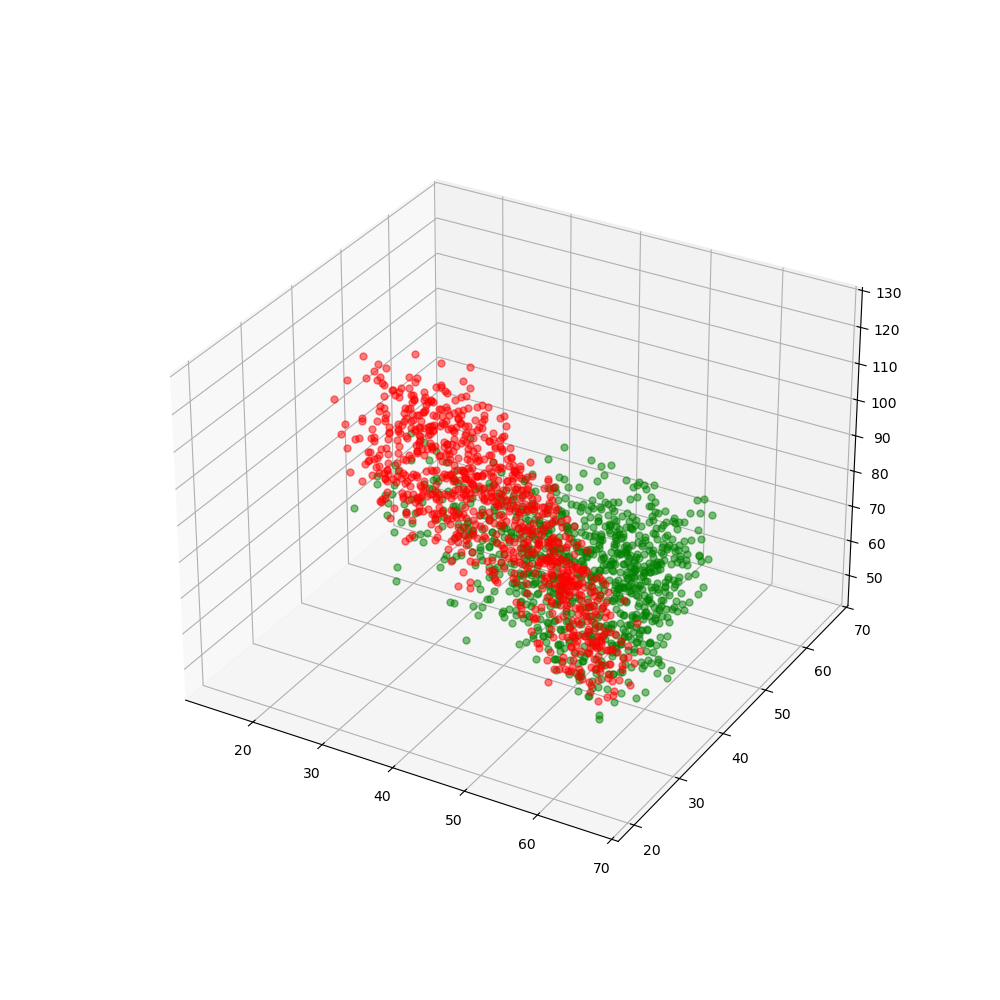

In [24]:
from matplotlib import pyplot as plt
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.plot(converged_pf[:,0], converged_pf[:,1], converged_pf[:,2], 'go', alpha=0.5, markersize=5)
ax.plot(converged_pf1[:,0], converged_pf1[:,1], converged_pf1[:,2], 'ro', alpha=0.5, markersize=5)
# ax.plot(pareto_front_final[:,0], pareto_front_final[:,1], pareto_front_final[:,2], 'bo', alpha=0.5, markersize=5)
plt.show()

In [25]:
obj1 = converged_pf[:, :3]
# obj2 = pareto_front_final[:, :3]
obj2 = converged_pf1[:, :3]

In [26]:
from pymoo.indicators.hv import HV
A = obj1.astype(np.float64)
B = obj2.astype(np.float64)
A_min = -A
B_min = -B

worst_min = np.max(np.vstack([A_min, B_min]), axis=0)
ref = worst_min * 1.05

hv = HV(ref_point=ref)

A_hv = hv(A_min)
B_hv = hv(B_min)

print(A_hv)
print(B_hv)
print((A_hv-B_hv)/B_hv)

88749.82999999999
81634.86999999991
0.08715589306383519


In [27]:
def eval_knapsack(knapsack,pf_actual,n_obj,scale,shape):
    pf_predicted = knapsack
    std_dev = np.sqrt(shape)*scale
    count = 0 
    pfdif = np.zeros(pf_actual.shape[0])
    for j in range(pf_actual.shape[0]):
        if np.any(pf_predicted[0:n_obj] > pf_actual[j,0:n_obj]):
            count = count + 1
        pfdif[j] = np.linalg.norm(pf_predicted[0:n_obj]/std_dev[0:n_obj] - pf_actual[j,0:n_obj]/std_dev[0:n_obj])
    pf_difference = np.min(pfdif) 
    domination_score = 1-count/pf_actual.shape[0]
    return domination_score, pf_difference

In [28]:
pf_difference = np.zeros(len(converged_pf))
domination_score = np.zeros(len(converged_pf))
for kk in range(len(converged_pf)):
    domination_score[kk], pf_difference[kk] = eval_knapsack(converged_pf[kk], pareto_front_final, n_obj, kn['scale'],kn['shape'])

In [ ]:
pf_difference = np.zeros(len(pareto_front_final))
domination_score = np.zeros(len(pareto_front_final))
for kk in range(len(pareto_front_final)):
    domination_score[kk], pf_difference[kk] = eval_knapsack(pareto_front_final[kk], converged_pf, n_obj, kn['scale'],kn['shape'])

In [ ]:
domination_score